<a href="https://colab.research.google.com/github/crypto-saac/test_demo/blob/master/Sentiment%20analysis%20using%20LSTN%20and%20GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

217022615 Sakhile Ngcobo



In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from numpy import array
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model

from IPython.display import SVG
#from keras.layers.vis_utils import model_to_dot


Reading the dataset which will be used 

In [45]:
filePath='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(filePath, header=0,encoding='latin-1', names=columns)



In [46]:
print(df['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599994    4
1599995    4
1599996    4
1599997    4
1599998    4
Name: target, Length: 1599999, dtype: int64


Classification of sentiment O is Negative and 4 is Positive


In [47]:
tmp_store = df[['target', 'text']]
tmp_store['target'].unique()
class_dict = {'"0"': 'negative', '"4"': 'positive'}
labels = tmp_store['target']
tmp_store.target



0          0
1          0
2          0
3          0
4          0
          ..
1599994    4
1599995    4
1599996    4
1599997    4
1599998    4
Name: target, Length: 1599999, dtype: int64

**Data cleaning involving removal of unwanted symbols and punctuation marks**

In [48]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
s_words = set(stopwords.words('english'))
snow_stemmer = SnowballStemmer("english")

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs and HTML tags
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in s_words)

    # Stem words
    text = ' '.join(snow_stemmer.stem(word) for word in text.split())

    return text

# Apply preprocessing function to 'text' column of 'tmp_store' dataframe
tmp_store['text'] = tmp_store['text'].apply(preprocess_text)

# Show first few rows of preprocessed 'tmp_store' dataframe
print(tmp_store.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   target                                               text
0       0  upset cant updat facebook text might cri resul...
1       0  kenichan dive mani time ball manag save rest g...
2       0                    whole bodi feel itchi like fire
3       0              nationwideclass behav im mad cant see
4       0                                kwesidei whole crew


<ipython-input-48-aa3fd2e85d38>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_store['text'] = tmp_store['text'].apply(preprocess_text)


In [49]:

a = LabelEncoder()
a.fit(tmp_store['target'])

tmp_store['target'] = a.transform(tmp_store['target'])
tmp_store.head()


<ipython-input-49-3fcb8b18c93a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_store['target'] = a.transform(tmp_store['target'])


,target,text
0,0,upset cant updat facebook text might cri resul...
1,0,kenichan dive mani time ball manag save rest g...
2,0,whole bodi feel itchi like fire
3,0,nationwideclass behav im mad cant see
4,0,kwesidei whole crew


In [50]:

x = tmp_store['text']
y = tmp_store['target']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [51]:
tokenizer_obj = Tokenizer()
X_train_str = [str(text) for text in X_train]
tokenizer_obj.fit_on_texts(X_train) 


# pad sequences

max_length = 30 
# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1


X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)



X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')
word_index =tokenizer_obj.word_index






Loading the Glove Word Embedding 

In [52]:
import locale 
locale.getpreferredencoding = lambda: "UTF-8"
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-05-07 22:45:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-07 22:45:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-07 22:45:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [53]:
gl_em_dict = {}
with open('glove.6B.300d.txt','r', encoding='utf-8') as f:
  for j in f:
    v = j.split()
    w = v[0]
    word_v = np.asarray(v[1:],'float32')
    gl_em_dict[w]=word_v


In [54]:
em_matrix = np.zeros((vocab_size, 300))
for w, i in word_index.items():
  em_vector = gl_em_dict.get(w)
  if em_vector is not None:
    em_matrix[i] = em_vector
    


In [55]:
from tensorflow.keras.layers import Embedding


embed_layer = Embedding(vocab_size, 300, weights=[em_matrix], input_length=30, trainable=False)


In [56]:


sequence_input = Input(shape=(30), dtype='int32')
embedded_sequences = embed_layer(sequence_input)
layer = SpatialDropout1D(0.2)(embedded_sequences)
layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(layer)
layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(512, activation='relu')(layer)
output = Dense(1, activation='sigmoid')(layer)

model = Model(sequence_input, output)


In [57]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])

In [58]:
history =model.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
10000/10000 - 2888s - loss: 0.5229 - accuracy: 0.7387 - val_loss: 0.4861 - val_accuracy: 0.7634 - 2888s/epoch - 289ms/step
Epoch 2/5
10000/10000 - 2908s - loss: 0.4952 - accuracy: 0.7574 - val_loss: 0.4797 - val_accuracy: 0.7676 - 2908s/epoch - 291ms/step
Epoch 3/5
10000/10000 - 2911s - loss: 0.4871 - accuracy: 0.7624 - val_loss: 0.4758 - val_accuracy: 0.7708 - 2911s/epoch - 291ms/step
Epoch 4/5
10000/10000 - 2897s - loss: 0.4827 - accuracy: 0.7652 - val_loss: 0.4733 - val_accuracy: 0.7723 - 2897s/epoch - 290ms/step
Epoch 5/5
10000/10000 - 2897s - loss: 0.4791 - accuracy: 0.7675 - val_loss: 0.4726 - val_accuracy: 0.7738 - 2897s/epoch - 290ms/step


In [59]:

print('Testing...')
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
2500/2500 [==============================] - 139s 56ms/step - loss: 0.4726 - accuracy: 0.7738
Test score: 0.47256729006767273
Test accuracy: 0.7738156318664551
Accuracy: 77.38%


In [60]:
print(acc)

0.7738156318664551


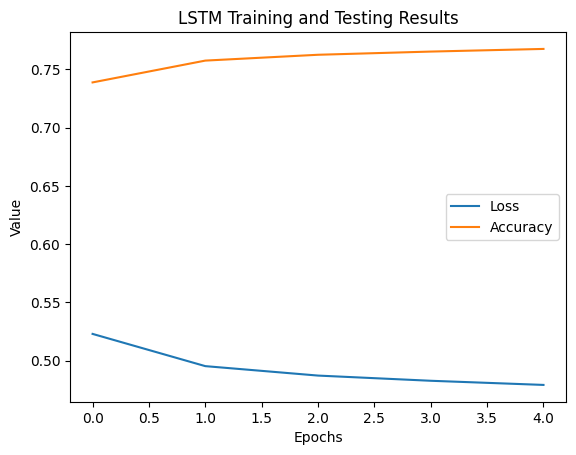

In [61]:
import matplotlib.pyplot as plt

# Create a line plot
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')

# Add labels and annotations
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM Training and Testing Results")
plt.legend()

# Show the plot
plt.show()



In [62]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model = Model(sequence_input, output)



Build model...


In [63]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 30, 300)           165546300 
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            93440     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 512)               33280     
                             

In [ ]:
print('Train...')

history_gru =model.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

Train...
Epoch 1/5
10000/10000 - 2918s - loss: 0.4769 - accuracy: 0.7687 - val_loss: 0.4719 - val_accuracy: 0.7746 - 2918s/epoch - 292ms/step
Epoch 2/5


In [ ]:
print('Testing...')
score_gru, acc_gru = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score_gru)
print('Test accuracy:', acc_gru)

print("Accuracy: {0:.2%}".format(acc_gru))

In [ ]:
import matplotlib.pyplot as plt

# Create a line plot
plt.plot(history_gru.history['loss'], label='Validation Loss')
plt.plot(history_gru.history['accuracy'], label='Validation Accuracy')

# Add labels and annotations
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("GRU Training and Testing Results")
plt.legend()

# Show the plot
plt.show()

